# 의료영상 용종검출 with UNet
---
- Data Augmentation 수행
    - 의료 영상의 특성상 데이터가 많이 부족한 점을 보완한다.
- tf.data.Dataset 활용
- 3가지 모델로 확인
    1. Encoder-Decoder
    2. UNet
    3. UNet++
- Loss 그래프, meanIoU계산, Segemtation결과 시각화

# 라이브러리 import

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.3.0


# 1. 데이터셋 준비
---
1. 데이터 로드
2. train_test_split
3. 시각화

#### 데이터를 처음 받는다면
---
```python
if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

import urllib.request
u = urllib.request.urlopen(url='https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip')
data = u.read()
u.close()

with open('sd_train.zip', "wb") as f :
    f.write(data)
    print('Data has been downloaded')

shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATASET_PATH)
zip_ref.close()
print('Data has been extracted.')
```

## 1-1. 데이터로드

In [2]:
DATASET_PATH=os.path.join(os.getenv('HOME'),'aiffel/medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

## 1-2. train_test_split

In [3]:
# 먼저 경로들을 정렬
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


## 1-3. 데이터 시각화
---
- train데이터와 label데이터 시각화

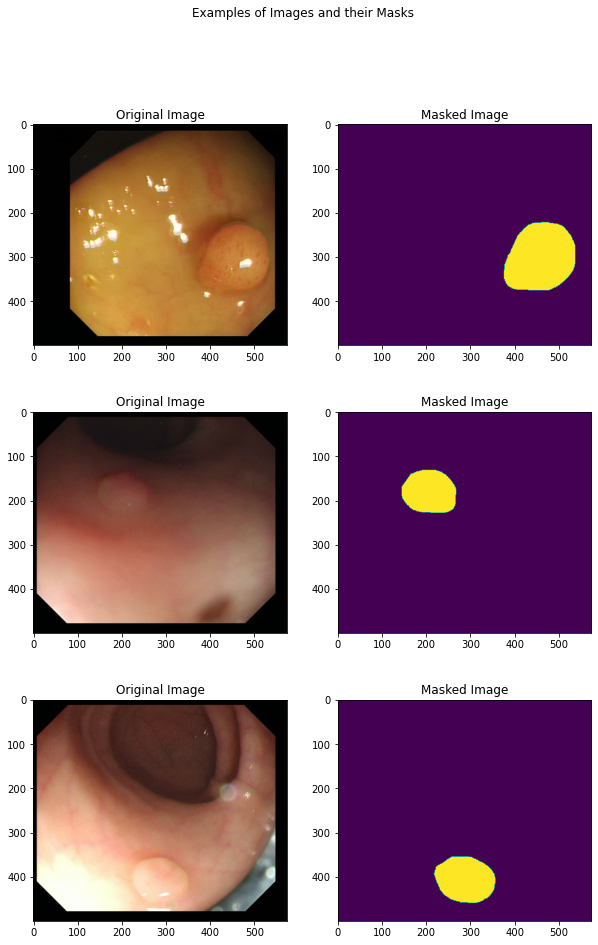

In [33]:
display_num = 3

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# 2. 데이터 파이프라인 설계

## 2-1. 하이퍼파라미터 설정

In [6]:
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 50

## 2-2. 입력 파이프라인 설계
---
- ```tf.data```활용
- ```read_image```함수
    - 경로로부터 이미지 읽기
    - normalization
- Augmentation 적용 (```augment```함수)
    - ```shift_img```함수
    - ```flip_img```함수

In [7]:
def read_img(img_path, label_path):
    # open & decode image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_bmp(img, channels=3)
    
    label = tf.io.read_file(label_path)
    label = tf.image.decode_bmp(label, channels=1)
    
    # resize & normalization(scaling)
    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label = tf.image.resize(label, resize)
    
    scale = 1/255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label = tf.cast(label, dtype=tf.float32) * scale
    
    return img, label

In [8]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                  -height_shift_range * img_shape[0],
                                                  height_shift_range * img_shape[0])
            
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                       [width_shift_range, height_shift_range])
    
    return output_img, label_img

In [9]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                   lambda: (tr_img, label_img))
    return tr_img, label_img

In [10]:
def _augment(img,
            label_img,
            resize=None,
            scale=1,
            hue_delta=0.,
            horizontal_flip=True,
            width_shift_range=0.05,
            height_shift_range=0.05,):
    
    if resize is not None:
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
    
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
        
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [11]:
def mk_base_dataset(filenames,
                   labels,
                   preproc_fn = functools.partial(_augment),
                   threads=4,
                   batch_size=batch_size,
                   is_train=True):
    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(read_img, num_parallel_calls=threads)
    
    if is_train:
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)
    
    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
train_dataset = mk_base_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = mk_base_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

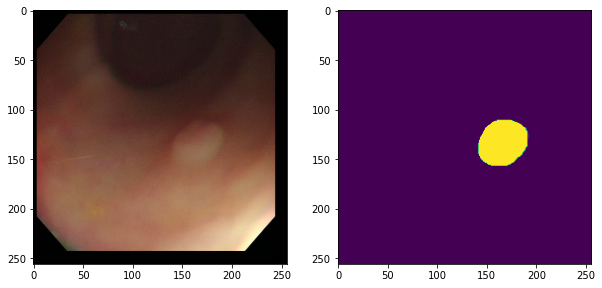

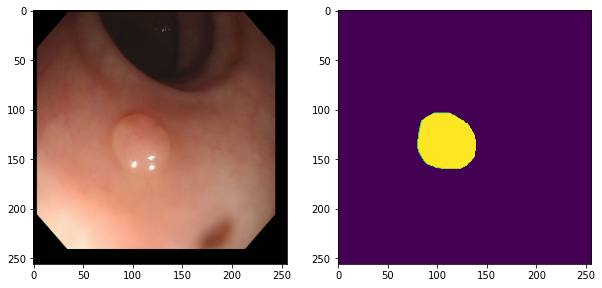

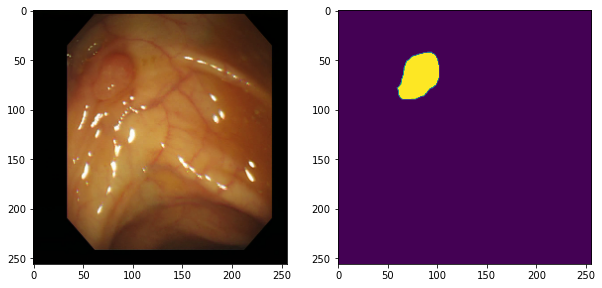

In [50]:
for images, labels in train_dataset.take(3):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# 3. 모델 구성

## 3-0. 하이퍼라라미터 세팅

In [13]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [14]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [15]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [16]:
def mk_cp_callback(model_name):
    checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt', model_name)
    
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='auto',
                                                save_best_only=True,
                                                verbose=0)
    return cp_callback

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = bce_dice_loss


In [18]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
cp_callback = mk_cp_callback('ed_model')

## 3-1. Encoder-Decoder

In [19]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [20]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [21]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [96]:
ed_model.compile(optimizer=optimizer, loss=loss, metrics=[dice_loss])
predictions = ed_model(tf.random.normal([batch_size, image_size, image_size, 3]))
ed_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [97]:
ed_model_history = ed_model.fit(train_dataset,
                               epochs = max_epochs,
                               steps_per_epoch=num_train_examples//batch_size,
                               validation_data=test_dataset,
                               validation_steps=num_test_examples//batch_size,
                               callbacks=[cp_callback, lr_callback, es])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 8s 138ms/step - loss: 1.0316 - dice_loss: 0.7233 - val_loss: 1.2216 - val_dice_loss: 0.7847

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 8s 130ms/step - loss: 0.9163 - dice_loss: 0.6953 - val_loss: 1.3240 - val_dice_loss: 0.8257

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 8s 131ms/step - loss: 0.8727 - dice_loss: 0.6668 - val_loss: 1.5798 - val_dice_loss: 0.8328

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 8s 132ms/step - loss: 0.7884 - dice_loss: 0.6034 - val_loss: 1.3682 - val_d

#### 결과 확인

In [22]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [23]:
def cal_mean_iou(model) :
    mean = []

    for images, labels in test_dataset:
        predictions = model(images, training=False)
        m = mean_iou(labels, predictions)
        mean.append(m)

    mean = np.array(mean)
    mean = np.mean(mean)
    print("mean_iou: {}".format(mean))

In [103]:
cal_mean_iou(ed_model)

mean_iou: 0.919986722458286


In [24]:
## Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

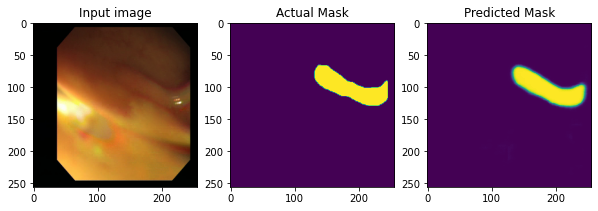

In [99]:
print_images(ed_model)

In [25]:
def plot_his(history):
    dice_loss = history.history['dice_loss']
    loss = history.history['loss']
    val_dice_loss = history.history['val_dice_loss']
    val_loss = history.history['val_loss']

    epochs_range = range(max_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Loss')
    plt.plot(epochs_range, dice_loss, label='Dice Loss')
    plt.legend(loc='upper right')
    plt.title('Train Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
    plt.legend(loc='upper right')
    plt.title('Valid Loss')
    plt.show()

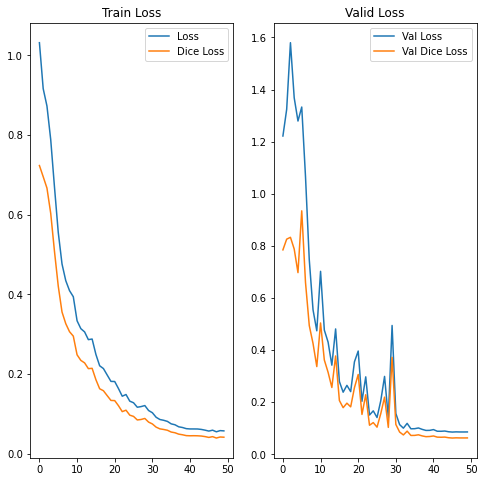

In [119]:
plot_his(ed_model_history)

## 3-2. UNet

In [26]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [27]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder

In [28]:
class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [29]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [109]:
unet_model = UNet()

In [115]:
unet_model.compile(optimizer=optimizer, loss=loss, metrics=[dice_loss])
predictions = unet_model(tf.random.normal([batch_size, image_size, image_size, 3]))
unet_model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [116]:
cp_callback = mk_cp_callback('unet_model')
unet_model_history = unet_model.fit(train_dataset,
                               epochs = max_epochs,
                               steps_per_epoch=num_train_examples//batch_size,
                               validation_data=test_dataset,
                               validation_steps=num_test_examples//batch_size,
                               callbacks=[cp_callback, lr_callback, es])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 37s 624ms/step - loss: 0.9869 - dice_loss: 0.7153 - val_loss: 33.1217 - val_dice_loss: 0.9128

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 37s 610ms/step - loss: 0.9192 - dice_loss: 0.7021 - val_loss: 17.6179 - val_dice_loss: 0.9994

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 37s 617ms/step - loss: 0.9013 - dice_loss: 0.6950 - val_loss: 1.1631 - val_dice_loss: 0.9198

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 37s 615ms/step - loss: 0.8800 - dice_loss: 0.6811 - val_loss: 1.0843 -

In [120]:
cal_mean_iou(unet_model)

mean_iou: 0.920304184140619


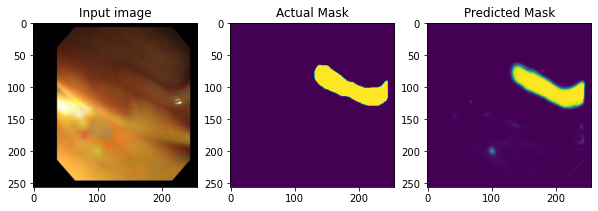

In [117]:
print_images(unet_model)

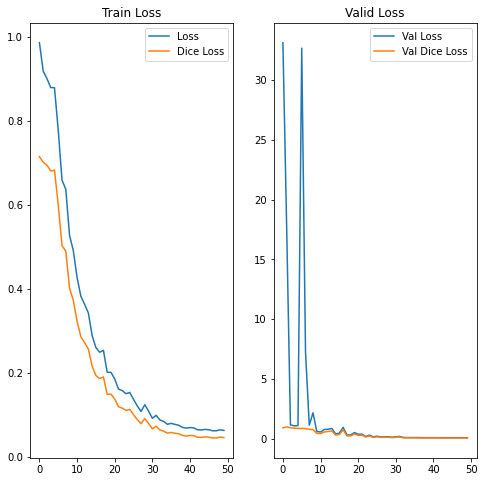

In [121]:
plot_his(unet_model_history)

## 3-3. 개선된 U-Net
---
- pretrained model활용
- Encoder부분을 pretrained model로 활용 => VGG16

In [41]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_4:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu_3:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu_3:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool_3:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu_3:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu_3:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool_3:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu_3:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu_3:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu_3:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool_3:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu_3:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu_3:0' shape=(None, 32, 32, 512) d

In [42]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [45]:
vggunet_model = Vgg16UNet()
vggunet_model.compile(optimizer=optimizer, loss=loss, metrics=[dice_loss])
predictions = vggunet_model(tf.random.normal([batch_size, image_size, image_size, 3]))

InvalidArgumentError: input must be 4-dimensional[256,256,3] [Op:Conv2D]

In [33]:
cp_callback = mk_cp_callback('vggunet_model')
vggunet_model_history = vggunet_model.fit(train_dataset,
                               epochs = max_epochs,
                               steps_per_epoch=num_train_examples//batch_size,
                               validation_data=test_dataset,
                               validation_steps=num_test_examples//batch_size,
                               callbacks=[cp_callback, lr_callback, es])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 24s 403ms/step - loss: 0.8163 - dice_loss: 0.5906 - val_loss: 1.4261 - val_dice_loss: 0.7971

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 25s 411ms/step - loss: 0.6062 - dice_loss: 0.4573 - val_loss: 0.9201 - val_dice_loss: 0.6529

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 23s 391ms/step - loss: 0.5059 - dice_loss: 0.3817 - val_loss: 1.3407 - val_dice_loss: 0.6585

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 26s 425ms/step - loss: 0.4676 - dice_loss: 0.3509 - val_loss: 0.5824 - v

In [35]:
cal_mean_iou(vggunet_model)

mean_iou: 0.43967053039149107


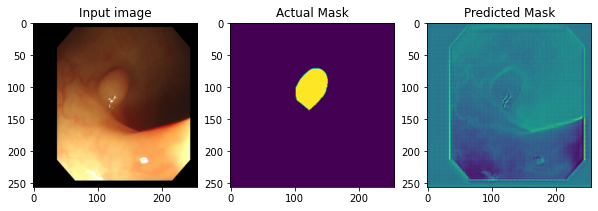

In [39]:
print_images(vggunet_model)

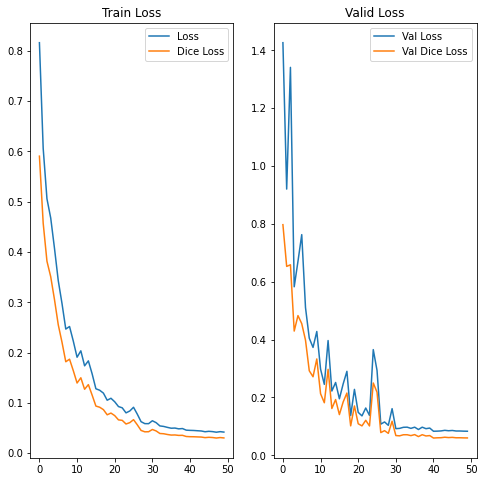

In [40]:
plot_his(vggunet_model_history)